In [6]:
import Pkg
#Pkg.add("StatsBase")
#Pkg.add("Distributions")
#Pkg.add("GraphPlot")
#Pkg.add("Plots")
#Pkg.add("GraphRecipes")
#Pkg.add("NetworkLayout")
#Pkg.add("GeometryTypes")
#Pkg.add("PaddedViews")
#Pkg.add("Cairo")
#Pkg.add("Compose")
#Pkg.add("Plots")
#Pkg.add("PyPlot")
using StatsBase
using Random
using Distributions
using LinearAlgebra
using LightGraphs
#using LightGraphs: smallgraph
using GraphPlot
#using GraphRecipes, Plots
#using NetworkLayout:SFDP
#using GeometryTypes
using PaddedViews
using Cairo, Compose
using Plots
ENV["PYTHON"] = raw"C:\Python38\python.exe" 
Pkg.build("PyCall")
using PyCall
pyplot() #change backend

#Pkg.add("JuMP")
#Pkg.add("GLPK")
using JuMP
using GLPK

   Building Conda ─→ `C:\Users\Bastiiii\.julia\packages\Conda\x5ml4\deps\build.log`
   Building PyCall → `C:\Users\Bastiiii\.julia\packages\PyCall\tqyST\deps\build.log`


In [8]:
"""
ForSample function https://github.com/JuliaStats/StatsBase.jl/blob/08d4b77a4b42ef8cadb67b98da65e7fbd9959e0b/src/sampling.jl#L445-L456

In our code, we use a simple sample fucntion, which has a stucture below
## sample([rng], a, [wv::AbstractWeights], n::Integer; replace=true, ordered=false) ##

For weight factors [wv::AbstractWeights], please see https://juliastats.org/StatsBase.jl/stable/weights/
There are different weight vectors. the type of weight in our code is Probability weights.
(https://juliastats.org/StatsBase.jl/stable/weights/#ProbabilityWeights-1)
Attention!
U need delcare you weight type in the sample function or the sample function will not take it as a valid input
##
example:(this is invalid) ✘ the right one is in our code.
sample(Grid_Label_flatten::AbstractArray,✘final_probability_flatten✘, amount_panel , replace = false, ordered= true)
##
"""


function Make_Question(n::Int,m::Int,factor::Int = 10, Density::Float64 = 0.8, option::String = "1-norm", distance::Int = 1)
    Grid_Label =  transpose( reshape(  collect(1:n*m),(n,m) ) )
    Grid_Label_flatten = reshape(Grid_Label,(m*n))
    
    px = abs.(((Grid_Label.-1) .% n).-((n-1)/2) )
    py = abs.(((Grid_Label.-1) .÷ n).-((n-1)/2))
    mesh_porbability = factor .^ -(px.+py)
    final_probability = mesh_porbability / sum(mesh_porbability)
    final_probability_flatten= reshape(final_probability, (m*n))
    
    amount_panel = Int(round(Density*n*m))
    
    allocation = sample(Grid_Label_flatten::AbstractArray, ProbabilityWeights(final_probability_flatten), amount_panel , replace = false, ordered= true)
    
    position_y = (allocation.-1).÷ n
    position_x = (allocation.-1).% n
    
    """
    make pairs to such structure to calculate the norm (for instance)
    2×32 Transpose{Int64,Array{Int64,2}}: 
     0  0  0  1  1  1  1  2  2  2  2  3  3  …  4  4  4  5  5  5  5  5  6  6  6  7
     2  3  4  2  3  4  5  2  3  4  5  0  1     3  4  5  0  2  3  4  5  1  2  4  0
    """
    position_pairs_pre = transpose(hcat(position_x,position_y))
    position_pairs = reshape(position_pairs_pre, (1 ,2 ,size(position_x)[1]))
    
    node_number = size(position_x)[1]
    Vector_2d_distance_set = zeros((1,2,node_number,node_number))
    [Vector_2d_distance_set[:,:,:,index] .= position_pairs .- position_pairs[:,:,index] for index in 1:node_number]
    
    norm_distance_set = zeros((node_number,node_number))
    if option == "1-norm"
        
        [norm_distance_set[index,:] .= [norm(slice,1) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]
    
    elseif option == "2-norm"
    
        [norm_distance_set[index,:] .= [norm(slice,2) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]
    else
        println("wrong input pal~")
        return 0
    end

    
    
    
    network_adv = norm_distance_set .<= distance
    
    nodelabel = collect(1:node_number+1).-1
    
    network = network_adv - I
    
    # In order to be align with python style, add node and padding 1 and 0 to left and top in sequence.  
        #      vertices  x0t|
        #     0 | 0 | 0 | 0 | 
   #vertices' 1 | * | * | * | Left 1
        #     1 | * | o | o | 
        #x0t  1 | * | o | o | 
        #    Top 2
    
    network_expand_left = collect(PaddedView(1, network, (1:node_number, 0:node_number)))
    
    #display(network_expand_left)
    
    network_expand_bottom = collect(PaddedView(0, network_expand_left, (0:node_number , 1:node_number+1 )))
    
    #display(network_expand_bottom)
    
    complete_network = network_expand_bottom
    
    pos = Dict()
    pos[0] = (m-0.5,n)
    for n in 1:length(position_x)
        pos[n] = (position_x[n],position_y[n])
    end
    
    
    return complete_network,allocation,node_number,pos , nodelabel;
end

Make_Question (generic function with 5 methods)

In [132]:
m = 2
n = 2
complete_network,allocation,node_number,pos,nodelabel = Make_Question(n::Int,m::Int);



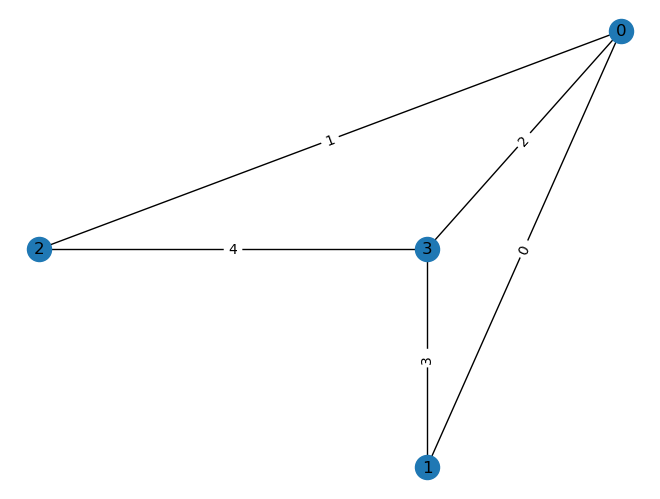

In [133]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random

def Draw_Graph(network,pos):
    G = nx.DiGraph()
    G = nx.from_numpy_array(network)
    
    # Label Edge with following rules:
    # 1. num(BUS)<num(branch)
    # 2. priority(BUS)>priority(branch)
    edge_label = {}
    for j, edge in enumerate(G.edges()):
        edge_label.update({(edge[0],edge[1]): str(j)})
       
    #print(edge_label)
    nx.draw(G,pos,with_labels=True)
    graph = nx.draw_networkx_edge_labels(G,pos,edge_labels = edge_label)
    #graph = nx.draw_networkx_edge_labels(G,pos)
    return G, edge_label, graph

"""
G, compelete_label, graph = py"Draw_Graph"(complete_network,pos);

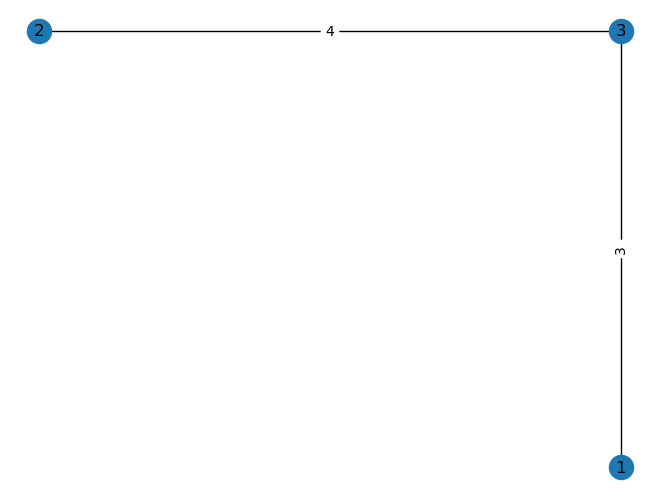

In [134]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random

def sub_Graph(network,pos,compelete_label):
    G_prime = nx.DiGraph()
    G_prime = nx.from_numpy_array(network)
    G_prime.remove_node(0)
    
    sub_edge_label = {}
    for j, edge in enumerate(G_prime.edges()):
        sub_edge_label.update({(edge[0],edge[1]): compelete_label[(edge[0],edge[1])]})
    
    nx.draw(G_prime,pos,with_labels=True)
    a = nx.draw_networkx_edge_labels(G_prime,pos,edge_labels = sub_edge_label)
    return G_prime, sub_edge_label

"""
G_prime, sub_edge_label = py"sub_Graph"(complete_network,pos,compelete_label);

In [135]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random

def edge_map (G, compelete_label, sub_edge_label):
    complete_edge = np.asarray(G.edges())
    new_map = np.zeros((len(compelete_label),len(compelete_label)))
    for edge in sub_edge_label:
    
        map_index_0, _ = np.where(complete_edge == edge[0])
        map_index_1, _ = np.where(complete_edge == edge[1])
    
        edge_index = np.int(compelete_label[(edge[0],edge[1])])
        new_map[edge_index][map_index_0] = 1
        new_map[edge_index][map_index_1] = 1
        
        new_map = new_map- np.diag(np.diag(new_map))
        
        lowest_edge = len(compelete_label)- len(sub_edge_label)
    return new_map, lowest_edge

"""
Final_map, lowest_edge_number = py"edge_map"(G, compelete_label, sub_edge_label);

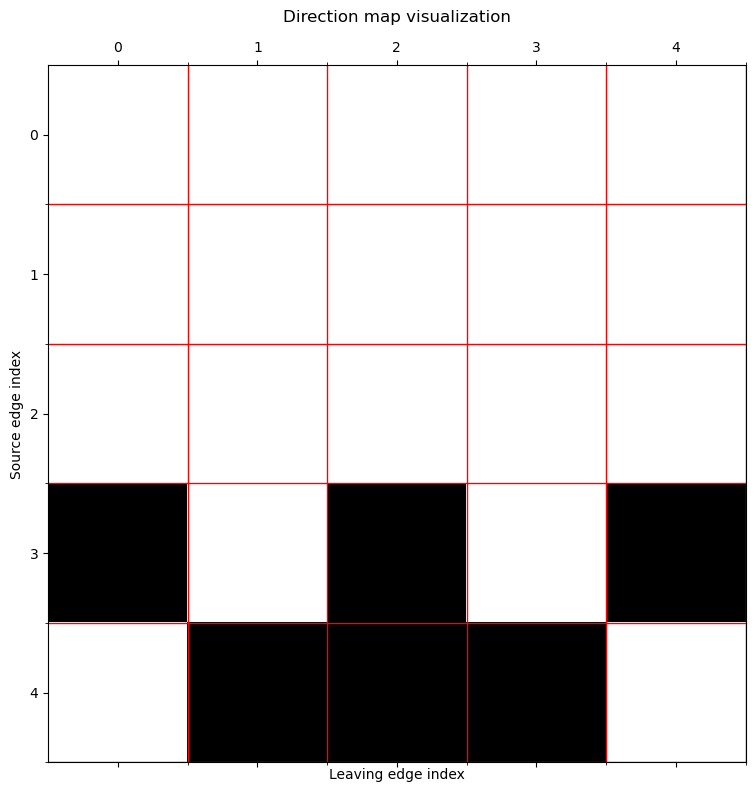

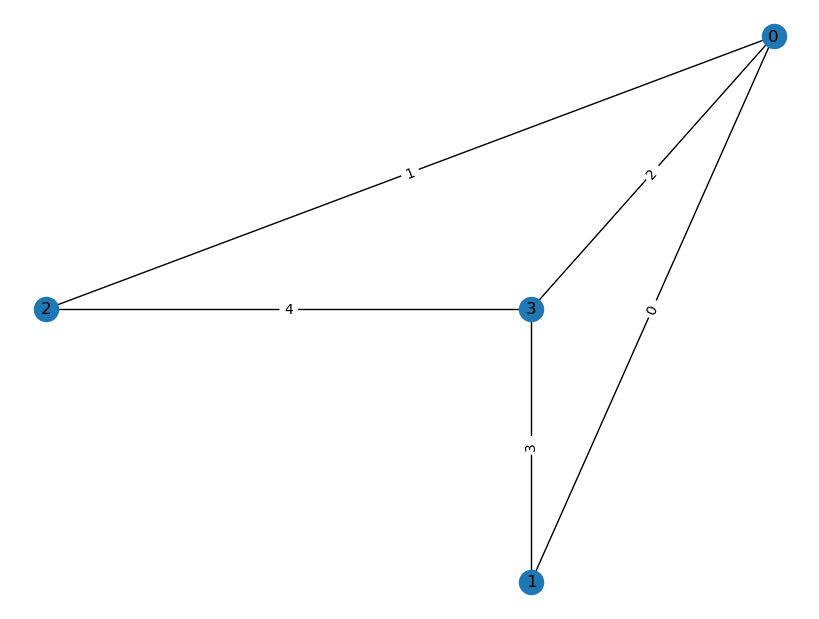

In [136]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt

def Draw_edge_map (Final_map, lowest_edge_number,compelete_label,pos,G):
    matfig = plt.figure(figsize=(9,9))
    plt.matshow(Final_map,cmap=plt.cm.binary,fignum=matfig.number)
    ax = plt.gca()
    #plt.matshow(Final_map,cmap=plt.cm.binary)
    plt.xlabel('Leaving edge index')
    plt.ylabel('Source edge index')
    plt.title ("Direction map visualization")

    # Major ticks
    ax.set_xticks(np.arange(0, Final_map.shape[0], step=1))
    ax.set_yticks(np.arange(0, Final_map.shape[0], step=1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, Final_map.shape[0], step=1))
    ax.set_yticklabels(np.arange(0, Final_map.shape[0], step=1))

    # Minor ticks
    ax.set_xticks(np.arange(0.5, Final_map.shape[0]+0.5, step=1), minor=True)
    ax.set_yticks(np.arange(0.5, Final_map.shape[0]+0.5, step=1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='r', linestyle='-', linewidth=1)



    plt.figure(2,figsize=(8,6)) 
    nx.draw(G,pos,with_labels=True)
    net_graph = nx.draw_networkx_edge_labels(G,pos,edge_labels = compelete_label)

"""
py"Draw_edge_map"(Final_map, lowest_edge_number,compelete_label,pos,G)

# Quick note of plt.show() is kind of deprecated.
# .julia\packages\PyCall\tqyST\src\pyeval.jl:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
# @pycheckn ccall((@pysym :PyEval_EvalCode),

In [137]:
lowest_edge_number

3

In [157]:
iout_map = [ findall( x ->  x > 0,Final_map[ie,:]) for ie in 1:size(Final_map)[1]]

5-element Array{Array{Int64,1},1}:
 []
 []
 []
 [1, 3, 5]
 [2, 3, 4]

In [158]:
iin_map = [ findall( x ->  x > 0,Final_map[:,ie]) for ie in 1:size(Final_map)[1]]

5-element Array{Array{Int64,1},1}:
 [4]
 [5]
 [4, 5]
 [5]
 [4]

In [142]:
Q = length(allocation) 　
Edge_set = size(Final_map)[1]
c_e = 1
p =1
println(Q)
println(Edge_set)


3
5


In [162]:
using JuMP
using GLPK
model = Model(with_optimizer(GLPK.Optimizer))
@variable(model, x[1:Edge_set, 1 : Q], Bin)
    
@objective(model, Min, 
        sum(
            sum(
                c_e * x[ie,id]
            for ie = 1: Edge_set)
        for id = 1: Q)
        +
        p*sum(
            sum(
                (id-1) * c_e * x[ie,id]
            for ie =lowest_edge_number + 1 : Edge_set)
        for id = 1: Q)
        )

@constraint(model,c1[ie in lowest_edge_number+1:Edge_set], sum(sum(x[iout,id] for id =1 :Q) for iout in iout_map[ie])== 1)
@constraint(model,c2[ie in lowest_edge_number+1:Edge_set], (sum(sum(id*x[iout,id] for id =1 :Q) for iout in iout_map[ie]) - sum(sum(id*x[iin,id] for id =1 :Q) for iin in iin_map[ie]))== 1)
@constraint(model,c3,sum(sum(id*x[ie,id] for ie in 1:lowest_edge_number+1) for id in 1:Q)== Q)

#@constraint(model, c2, 7x + 12y >= 120)
print(model)


Min x[1,1] + x[2,1] + x[3,1] + x[4,1] + x[5,1] + x[1,2] + x[2,2] + x[3,2] + 2 x[4,2] + 2 x[5,2] + x[1,3] + x[2,3] + x[3,3] + 3 x[4,3] + 3 x[5,3]
Subject to
 x[1,1] + x[1,2] + x[1,3] + x[3,1] + x[3,2] + x[3,3] + x[5,1] + x[5,2] + x[5,3] == 1.0
 x[2,1] + x[2,2] + x[2,3] + x[3,1] + x[3,2] + x[3,3] + x[4,1] + x[4,2] + x[4,3] == 1.0
 x[1,1] + 2 x[1,2] + 3 x[1,3] + x[3,1] + 2 x[3,2] + 3 x[3,3] == 1.0
 x[2,1] + 2 x[2,2] + 3 x[2,3] + x[3,1] + 2 x[3,2] + 3 x[3,3] == 1.0
 x[1,1] + x[2,1] + x[3,1] + x[4,1] + 2 x[1,2] + 2 x[2,2] + 2 x[3,2] + 2 x[4,2] + 3 x[1,3] + 3 x[2,3] + 3 x[3,3] + 3 x[4,3] == 3.0
 x[1,1] binary
 x[1,2] binary
 x[1,3] binary
 x[2,1] binary
 x[2,2] binary
 x[2,3] binary
 x[3,1] binary
 x[3,2] binary
 x[3,3] binary
 x[4,1] binary
 x[4,2] binary
 x[4,3] binary
 x[5,1] binary
 x[5,2] binary
 x[5,3] binary


In [163]:
optimize!(model)
@show termination_status(model)
#@show primal_status(model)
#@show dual_status(model)
@show objective_value(model)
@show JuMP.value.(x)
#@show shadow_price(c1)
#@show shadow_price(c2)

termination_status(model) = MathOptInterface.INFEASIBLE


MathOptInterface.ResultIndexBoundsError{MathOptInterface.ObjectiveValue}: Result index of attribute MathOptInterface.ObjectiveValue(1) out of bounds. There are currently 0 solution(s) in the model.

In [164]:
# 需要改的部分
#1、 Python 生成的边图应该保持方向性，虽然这样会double 边的数量
#2、注意 原论文公式2，3  i应该只覆盖比lowest_edge_number的edge的编号（白话说就是只统计双向边的进出流量） 
#3、应增添每个顶点的进出edge 的黑白图